In [8]:
file_path = '/home/home/Documents/Val/RAW/iso 20 min c2.txt'  # or .csv, .txt, etc.

SMLM DATA PROCESSING PIPELINE
✓ Locan library available
✓ SciPy available for fast KD-tree (blinks calc)
------------------------------------------------------------
STEP 1: LOADING DATA
------------------------------------------------------------
✓ Successfully loaded 111,307 localizations using locan
  Columns found: 13

Column mapping:
   0: 'original_index'
   1: 'frame'
   2: 'frames_number'
   3: 'frames_missing'
   4: 'position_x'
   5: 'position_y'
   6: 'uncertainty'
   7: 'intensity'
   8: 'local_background_sigma'
   9: 'chi_square'
  10: 'psf_half_width'
  11: 'channel'
  12: 'slice_z'

Identified column mappings:
  x               → 'position_x'
  y               → 'position_y'
  photons         → 'intensity'
  precision       → 'uncertainty'
  frame           → 'frame'
  background      → 'local_background_sigma'
  chi_square      → 'chi_square'
  psf_half_width  → 'psf_half_width'

------------------------------------------------------------
STEP 2: EXTRACTING METADATA
--

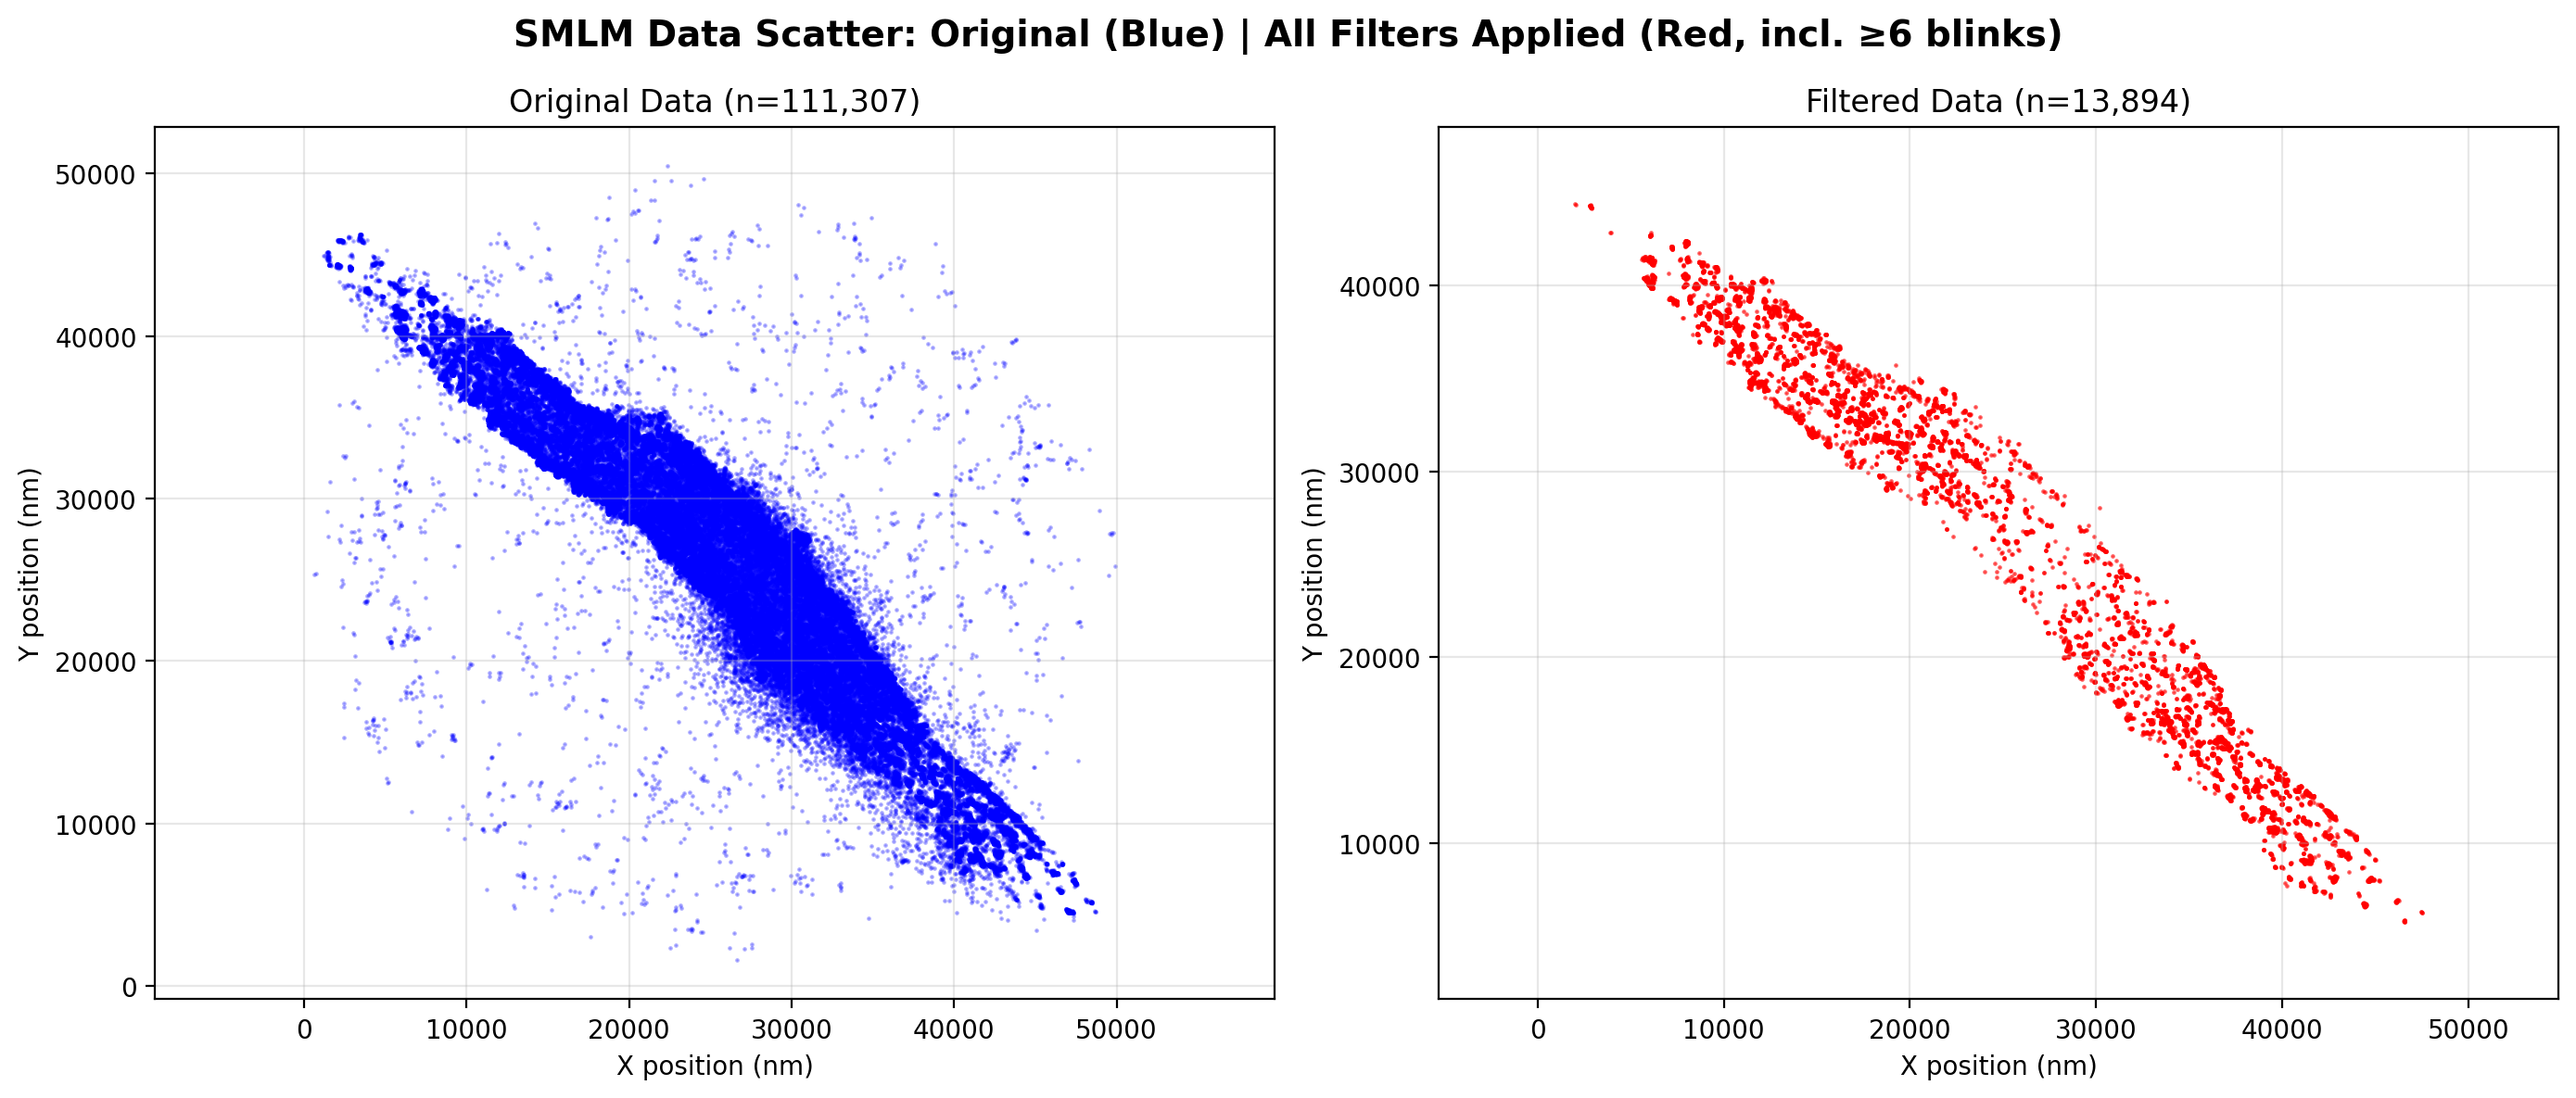

✓ Visualization complete (Original in blue, fully filtered in red incl. ≥6 blinks)

------------------------------------------------------------
STEP 6: FILTER PARAMETER DISTRIBUTIONS
------------------------------------------------------------


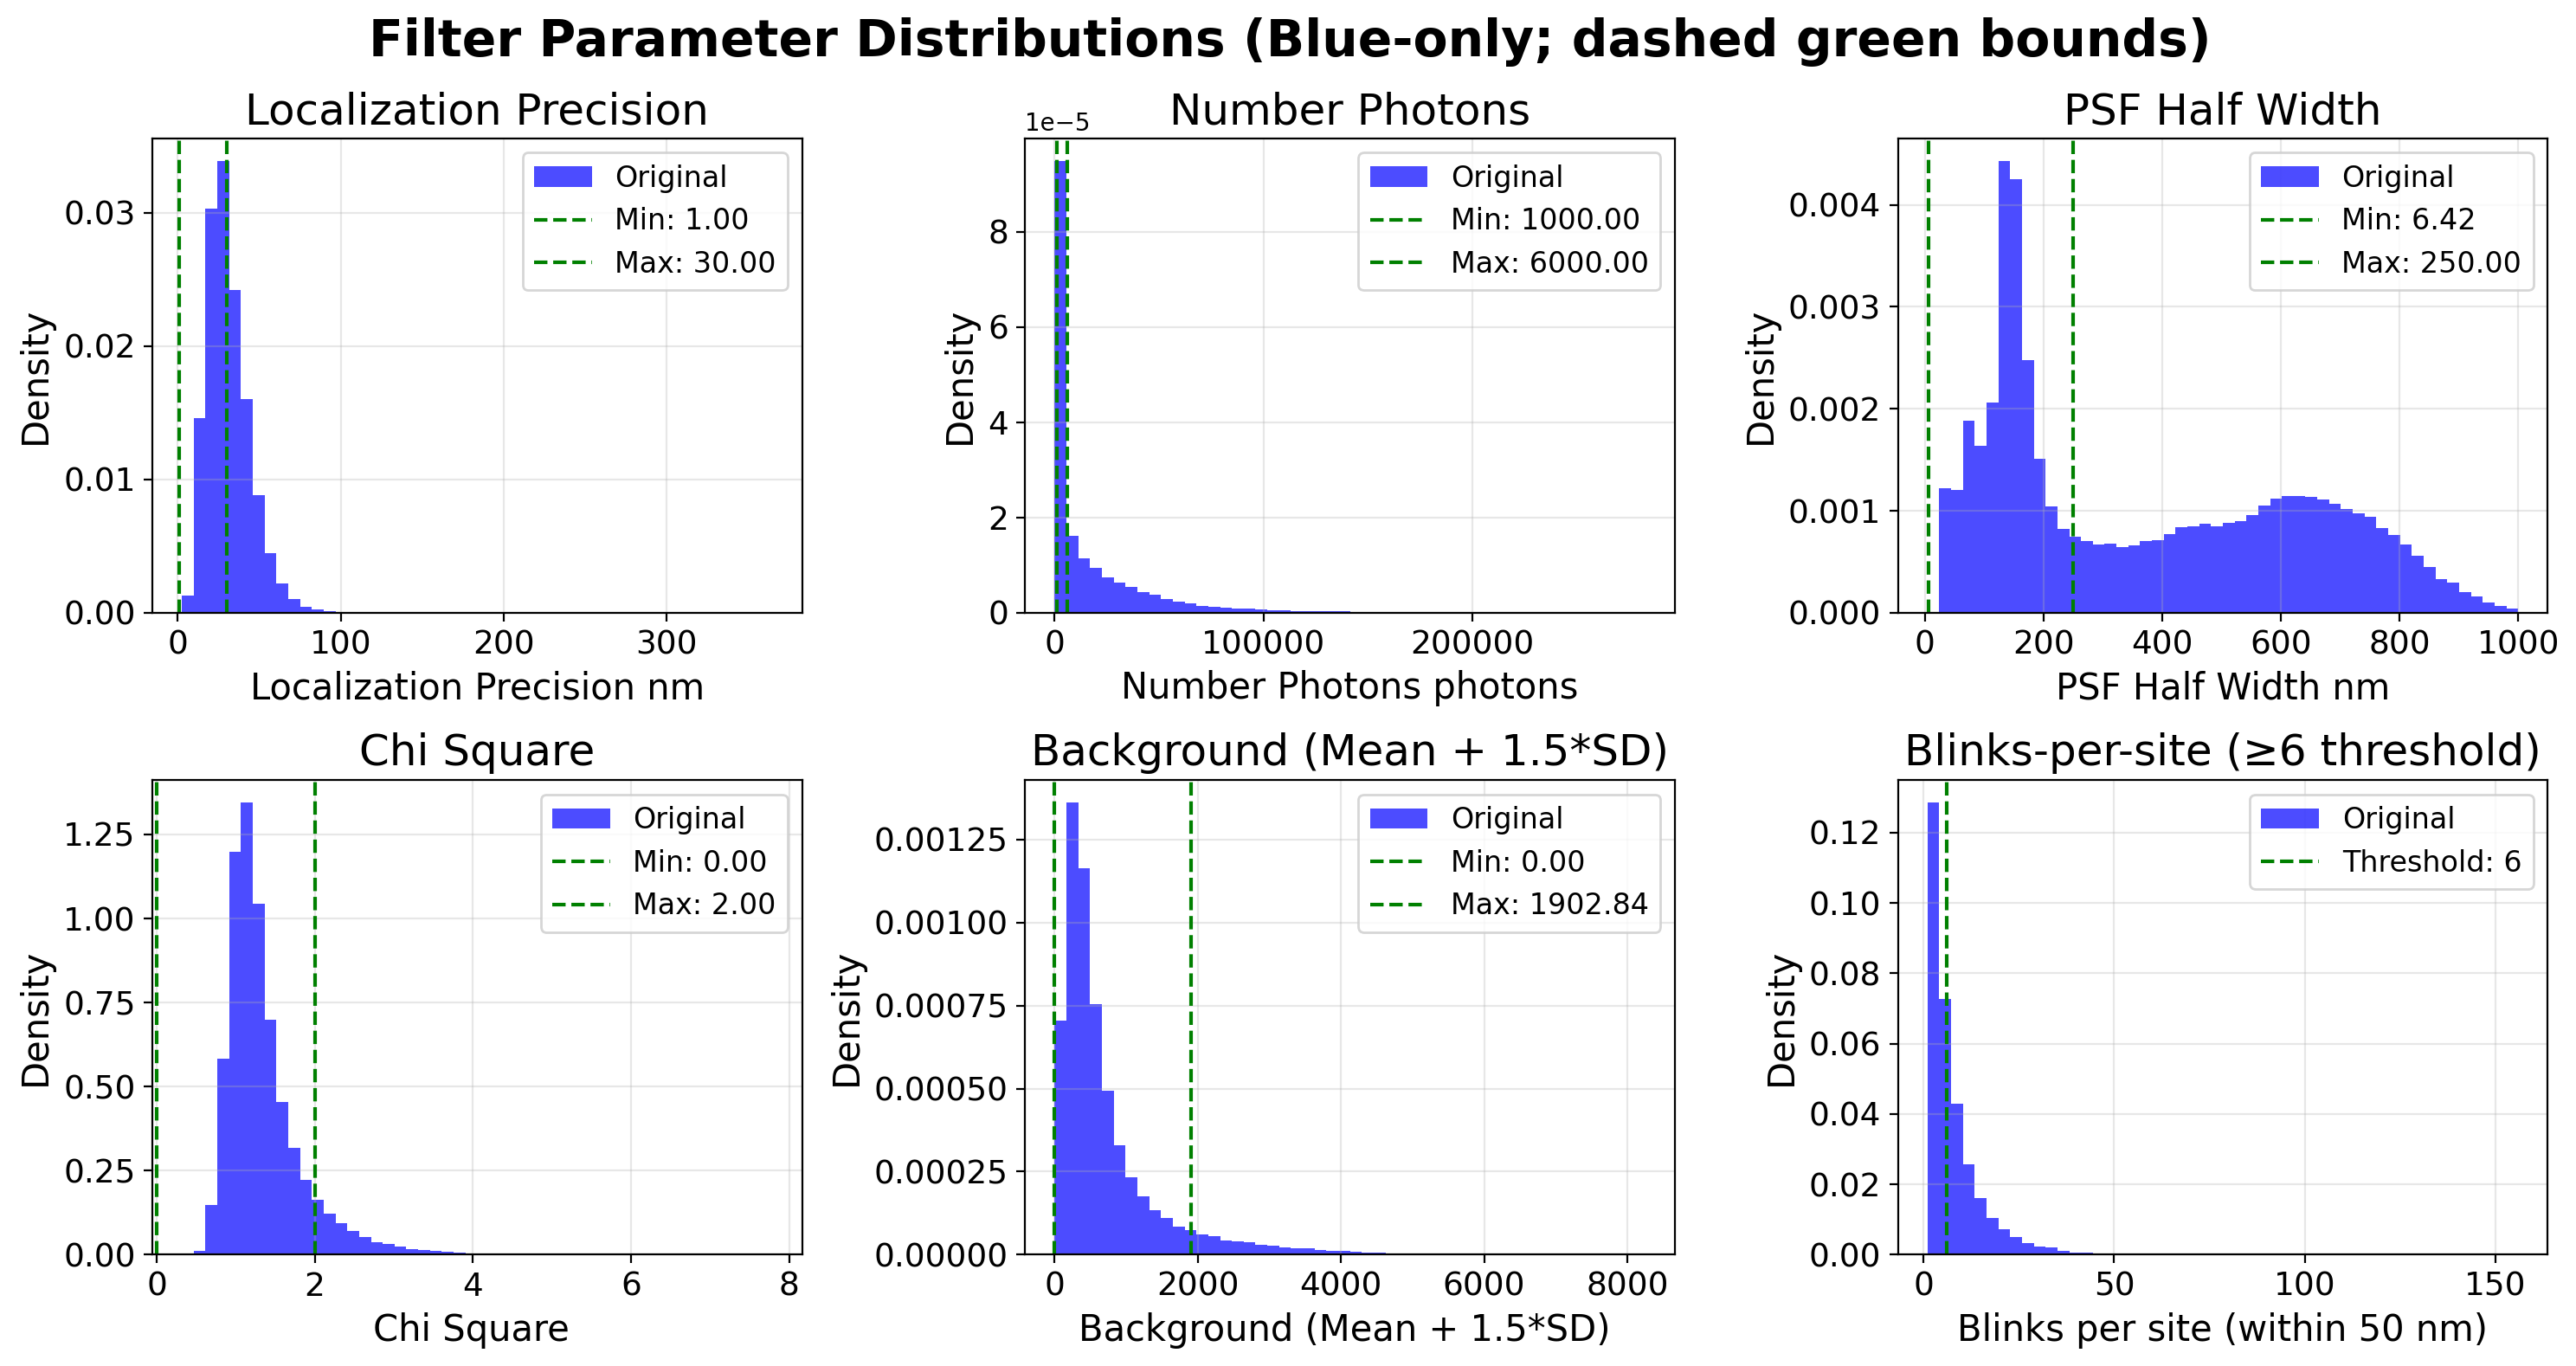

✓ Parameter distribution plots complete (blue-only; kept dashed green lines)

STEP 7: REFORMATTING OUTPUT
Column renaming applied:
  'original_index' → 'Index'
  'frame' → 'First Frame'
  'frames_number' → 'Number Frames'
  'frames_missing' → 'Frames Missing'
  'position_x' → 'Position X [nm]'
  'position_y' → 'Position Y [nm]'
  'uncertainty' → 'Precision [nm]'
  'intensity' → 'Number Photons'
  'local_background_sigma' → 'Background variance'
  'chi_square' → 'Chi square'
  'psf_half_width' → 'PSF half width [nm]'
  'channel' → 'Channel'
  'slice_z' → 'Z Slice'

PROCESSING COMPLETE!
Final dataset: 13,894 localizations ready for analysis

Final column names:
   0: Index
   1: First Frame
   2: Number Frames
   3: Frames Missing
   4: Position X [nm]
   5: Position Y [nm]
   6: Precision [nm]
   7: Number Photons
   8: Background variance
   9: Chi square
  10: PSF half width [nm]
  11: Channel
  12: Z Slice
  13: blinks_per_site

First 5 rows of final data:
      Index  First Frame  N

In [13]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Global plotting defaults
plt.rcParams['figure.dpi'] = 200  # ensure all figures render at 200 DPI

print("="*60)
print("SMLM DATA PROCESSING PIPELINE")
print("="*60)

# Try to import locan
try:
    import locan as lc
    LOCAN_AVAILABLE = True
    print("✓ Locan library available")
except ImportError:
    LOCAN_AVAILABLE = False
    print("⚠ WARNING: locan not available. Will use pandas fallback method.")

# Try to import a fast KD-tree for the blinks calculation
try:
    from scipy.spatial import cKDTree
    SCIPY_AVAILABLE = True
    print("✓ SciPy available for fast KD-tree (blinks calc)")
except Exception:
    SCIPY_AVAILABLE = False
    print("⚠ SciPy not available. Will use a grid-based fallback for blinks calc (may be slower).")

print("-"*60)
print("STEP 1: LOADING DATA")
print("-"*60)

# Expect `file_path` to be defined by the caller (same style as your originals)
if LOCAN_AVAILABLE:
    try:
        locdata = lc.load_Elyra_file(str(file_path))
        df = locdata.dataframe
        print(f"✓ Successfully loaded {len(df):,} localizations using locan")
        print(f"  Columns found: {len(df.columns)}")
    except Exception as e:
        print(f"✗ Locan Elyra loader failed: {e}")
        print("  Falling back to pandas TSV reader...")
        df = pd.read_csv(file_path, sep='\t', encoding='latin1')
        print(f"✓ Loaded {len(df):,} rows using pandas fallback")
else:
    df = pd.read_csv(file_path, sep='\t', encoding='latin1')
    print(f"✓ Loaded {len(df):,} rows using pandas")

# Display column information
print("\nColumn mapping:")
for i, col in enumerate(df.columns):
    print(f"  {i:2d}: '{col}'")

# Map column names to standardized keys
column_mapping = {}
column_variations = {
    'x': ['Position X [nm]', 'position_x', 'x', 'X'],
    'y': ['Position Y [nm]', 'position_y', 'y', 'Y'],
    'photons': ['Number Photons', 'intensity', 'photons', 'Number_Photons'],
    'precision': ['Precision [nm]', 'uncertainty', 'precision'],
    'frame': ['First Frame', 'frame', 'Frame'],
    'background': ['Background variance', 'local_background_sigma', 'background', 'Background'],
    'chi_square': ['chi_square', 'Chi_Square', 'chi2'],
    'psf_half_width': ['psf_half_width', 'PSF_Half_Width', 'psf_width']
}

actual_columns = df.columns.tolist()
for key, variations in column_variations.items():
    for var in variations:
        if var in actual_columns:
            column_mapping[key] = var
            break

print("\nIdentified column mappings:")
for key, col in column_mapping.items():
    print(f"  {key:15s} → '{col}'")

# Extract metadata from file tail (if present)
print("\n" + "-"*60)
print("STEP 2: EXTRACTING METADATA")
print("-"*60)

metadata = {}
try:
    with open(file_path, 'r', encoding='latin1', errors='ignore') as f:
        lines = f.readlines()
    for line in lines[-50:]:
        if 'VoxelSizeX' in line:
            import re
            m = re.search(r'VoxelSizeX\s*:\s*([\d.]+)', line)
            if m: metadata['VoxelSizeX'] = float(m.group(1))
        if 'VoxelSizeY' in line:
            m = re.search(r'VoxelSizeY\s*:\s*([\d.]+)', line)
            if m: metadata['VoxelSizeY'] = float(m.group(1))
        if 'SizeX' in line and 'VoxelSizeX' not in line:
            m = re.search(r'SizeX\s*:\s*(\d+)', line)
            if m: metadata['SizeX'] = int(m.group(1))
        if 'SizeY' in line and 'VoxelSizeY' not in line:
            m = re.search(r'SizeY\s*:\s*(\d+)', line)
            if m: metadata['SizeY'] = int(m.group(1))
    if metadata:
        print("✓ Extracted metadata:")
        for key, value in metadata.items():
            print(f"  {key}: {value}")
    else:
        print("⚠ No metadata found in file")
except Exception as e:
    print(f"✗ Could not extract metadata: {e}")

# Display initial data statistics
print("\n" + "-"*60)
print("STEP 3: INITIAL DATA SUMMARY")
print("-"*60)
print(f"Total localizations: {len(df):,}")
print(f"Data shape: {df.shape}")
print("\nFirst 3 rows:")
print(df.head(3))

# Display coordinate ranges
if 'x' in column_mapping and 'y' in column_mapping:
    x_col = column_mapping['x']
    y_col = column_mapping['y']
    print(f"\nSpatial extent:")
    print(f"  X range: {df[x_col].min():.1f} to {df[x_col].max():.1f} nm")
    print(f"  Y range: {df[y_col].min():.1f} to {df[y_col].max():.1f} nm")

# ------------------------------
# STEP 4: APPLYING NUMERIC FILTERS
# ------------------------------
print("\n" + "="*60)
print("STEP 4: APPLYING FILTERS")
print("="*60)

filters = {
    'uncertainty': {'min': 1.00, 'max': 30.00, 'unit': 'nm', 'name': 'Localization Precision'},
    'intensity': {'min': 1000, 'max': 6000, 'unit': 'photons', 'name': 'Number Photons'},
    'psf_half_width': {'min': 6.42, 'max': 250.00, 'unit': 'nm', 'name': 'PSF Half Width'},
    'chi_square': {'min': 0.00, 'max': 2.00, 'unit': '', 'name': 'Chi Square'}
}

background_col = 'local_background_sigma'
if background_col in df.columns:
    bg_mean = df[background_col].mean()
    bg_std = df[background_col].std()
    bg_upper = bg_mean + 1.5 * bg_std
    bg_lower = 0
    filters[background_col] = {
        'min': bg_lower,
        'max': bg_upper,
        'unit': '',
        'name': 'Background (Mean + 1.5*SD)',
        'special': True,
        'mean': bg_mean,
        'std': bg_std
    }

original_count = len(df)
df_filtered = df.copy()

print("\nFilter specifications:")
print("-" * 50)
for col, params in filters.items():
    if col in df.columns:
        print(f"\n{params['name']}:")
        print(f"  Column: '{col}'")
        print(f"  Range: {params['min']:.2f} to {params['max']:.2f} {params['unit']}")
        if 'special' in params and params['special']:
            print(f"  Method: Dynamic (Mean={params['mean']:.2f}, SD={params['std']:.2f})")
        initial_min = df_filtered[col].min()
        initial_max = df_filtered[col].max()
        initial_mean = df_filtered[col].mean()
        print(f"  Before: min={initial_min:.2f}, max={initial_max:.2f}, mean={initial_mean:.2f}")
        before_count = len(df_filtered)
        mask = (df_filtered[col] >= params['min']) & (df_filtered[col] <= params['max'])
        df_filtered = df_filtered[mask]
        after_count = len(df_filtered)
        removed = before_count - after_count
        percent_removed = (removed / before_count * 100) if before_count > 0 else 0
        print(f"  Removed: {removed:,} localizations ({percent_removed:.1f}%)")
        print(f"  Remaining: {after_count:,}")
        if len(df_filtered) > 0:
            final_min = df_filtered[col].min()
            final_max = df_filtered[col].max()
            final_mean = df_filtered[col].mean()
            print(f"  After: min={final_min:.2f}, max={final_max:.2f}, mean={final_mean:.2f}")
    else:
        print(f"\n⚠ Warning: Column '{col}' not found in data")

# ------------------------------
# STEP 4b: COMPUTE BLINKS & APPLY ≥6 AS PART OF FINAL FILTER
# ------------------------------
print("\n" + "-"*60)
# --- MODIFIED LINE (VARIABLE) ---
blinks_threshold = 6
# --- MODIFIED LINE (PRINT) ---
print(f"STEP 4b: COMPUTE BLINKS-PER-SITE & APPLY ≥{blinks_threshold} TO FINAL SET")
print("-"*60)

blinks_radius_nm = 50.0  # neighborhood radius in nm

def compute_blinks_per_site(xy_nm, radius_nm):
    """
    Returns an array of neighbor counts (including self) within radius_nm for each point.
    Uses SciPy cKDTree if available, otherwise a grid-based fallback.
    """
    n = xy_nm.shape[0]
    if n == 0:
        return np.array([], dtype=int)
    if SCIPY_AVAILABLE:
        tree = cKDTree(xy_nm)
        nbhd = tree.query_ball_point(xy_nm, r=radius_nm, return_sorted=False)
        return np.fromiter((len(idx_list) for idx_list in nbhd), dtype=int, count=n)
    else:
        # Grid / spatial hashing fallback
        cell = radius_nm
        keys = np.floor(xy_nm / cell).astype(int)
        buckets = {}
        for i, (gx, gy) in enumerate(keys):
            buckets.setdefault((gx, gy), []).append(i)
        offsets = [(dx, dy) for dx in (-1, 0, 1) for dy in (-1, 0, 1)]
        r2 = radius_nm * radius_nm
        counts = np.zeros(n, dtype=int)
        for i, (gx, gy) in enumerate(keys):
            candidates = []
            for dx, dy in offsets:
                candidates.extend(buckets.get((gx + dx, gy + dy), []))
            diffs = xy_nm[candidates] - xy_nm[i]
            d2 = diffs[:, 0]**2 + diffs[:, 1]**2
            counts[i] = int(np.sum(d2 <= r2))
        return counts

blinks_available = ('x' in column_mapping and 'y' in column_mapping)
if blinks_available:
    coords = df[[column_mapping['x'], column_mapping['y']]].to_numpy(dtype=float, copy=False)
    print(f"Computing neighbors within {blinks_radius_nm:.0f} nm for {len(coords):,} points...")
    blinks_counts = compute_blinks_per_site(coords, blinks_radius_nm)

    # Attach to full df
    df = df.copy()
    df['blinks_per_site'] = blinks_counts

    # Ensure df_filtered can see 'blinks_per_site'
    if 'blinks_per_site' not in df_filtered.columns:
        df_filtered = df_filtered.join(df[['blinks_per_site']], how='left')

    # Apply ≥6 blinks to the final filtered set
    print(f"Adding ≥{blinks_threshold} blinks to the final mask...")
    before = len(df_filtered)
    df_filtered = df_filtered[df_filtered['blinks_per_site'] >= blinks_threshold]
    after = len(df_filtered)
    print(f"  Applied ≥{blinks_threshold} blinks: removed {before - after:,}; remaining {after:,}")

    n_blinks_total = int((df['blinks_per_site'] >= blinks_threshold).sum())
    print(f"✓ Computed blinks-per-site. Points with ≥{blinks_threshold} blinks overall: {n_blinks_total:,} "
          f"({(n_blinks_total/len(df)*100 if len(df)>0 else 0):.1f}%)")
else:
    print("⚠ Cannot compute/apply blinks-per-site: x/y columns not found")

# ------------------------------
# FILTERING SUMMARY (INCLUDES BLINKS)
# ------------------------------
print("\n" + "="*60)
# --- MODIFIED LINE (PRINT) ---
print(f"FILTERING SUMMARY (incl. ≥{blinks_threshold} blinks)")
print("="*60)
total_removed = original_count - len(df_filtered)
percent_retained = (len(df_filtered) / original_count * 100) if original_count > 0 else 0
print(f"Original localizations: {original_count:,}")
print(f"Filtered localizations: {len(df_filtered):,}")
print(f"Total removed: {total_removed:,}")
print(f"Retention rate: {percent_retained:.1f}%")

# Final spatial extent
if 'x' in column_mapping and 'y' in column_mapping and len(df_filtered) > 0:
    print(f"\nFiltered spatial extent:")
    print(f"  X range: {df_filtered[x_col].min():.1f} to {df_filtered[x_col].max():.1f} nm")
    print(f"  Y range: {df_filtered[y_col].min():.1f} to {df_filtered[y_col].max():.1f} nm")

# ------------------------------
# STEP 5: VISUALIZATION (SCATTER)
# ------------------------------
print("\n" + "-"*60)
print("STEP 5: VISUALIZATION (SCATTER)")
print("-"*60)

if 'x' in column_mapping and 'y' in column_mapping:
    # Two-panel scatter: Original (blue) and AFTER ALL FILTERS (red, incl. ≥6 blinks)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=200)

    # Panel 1: Original data (blue)
    axes[0].scatter(df[column_mapping['x']],
                    df[column_mapping['y']],
                    s=0.5, alpha=0.3, c='blue')
    axes[0].set_xlabel('X position (nm)')
    axes[0].set_ylabel('Y position (nm)')
    axes[0].set_title(f'Original Data (n={original_count:,})')
    axes[0].axis('equal')
    axes[0].grid(True, alpha=0.3)

    # Panel 2: Fully filtered data (red, includes ≥6 blinks if available)
    axes[1].scatter(df_filtered[column_mapping['x']],
                    df_filtered[column_mapping['y']],
                    s=0.5, alpha=0.6, c='red')
    axes[1].set_xlabel('X position (nm)')
    axes[1].set_ylabel('Y position (nm)')
    axes[1].set_title(f'Filtered Data (n={len(df_filtered):,})')
    axes[1].axis('equal')
    axes[1].grid(True, alpha=0.3)

    # --- MODIFIED LINE (TITLE) ---
    plt.suptitle(f'SMLM Data Scatter: Original (Blue) | All Filters Applied (Red, incl. ≥{blinks_threshold} blinks)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # --- MODIFIED LINE (PRINT) ---
    print(f"✓ Visualization complete (Original in blue, fully filtered in red incl. ≥{blinks_threshold} blinks)")
else:
    print("⚠ Cannot create visualization: x/y columns not found")

# ------------------------------
# STEP 6: FILTER PARAMETER DISTRIBUTIONS (blue-only)
# ------------------------------
print("\n" + "-"*60)
print("STEP 6: FILTER PARAMETER DISTRIBUTIONS")
print("-"*60)

# --- NEW CODE ---
# Scalar to control text sizes on these histogram plots
hist_text_scalar = 1.5
label_fs = 10 * hist_text_scalar
title_fs = 12 * hist_text_scalar
tick_fs = 9 * hist_text_scalar
legend_fs = 8 * hist_text_scalar
suptitle_fs = 14 * hist_text_scalar
# --- END NEW CODE ---

n_params = len(filters)
if n_params > 0:
    fig, axes = plt.subplots(2, 3, figsize=(15, 8), dpi=200)
    axes = axes.flatten()

    plot_idx = 0
    # First 5 panels: blue-only histograms with dashed green bounds
    for col, params in filters.items():
        if col in df.columns and plot_idx < 5:
            ax = axes[plot_idx]
            ax.hist(df[col].dropna(), bins=50, alpha=0.7, color='blue', label='Original', density=True)
            ax.axvline(params['min'], color='green', linestyle='--', label=f'Min: {params["min"]:.2f}')
            ax.axvline(params['max'], color='green', linestyle='--', label=f'Max: {params["max"]:.2f}')
            
            # --- MODIFIED LINES (APPLY FONT SCALAR) ---
            ax.set_xlabel(f'{params["name"]} {params["unit"]}', fontsize=label_fs)
            ax.set_ylabel('Density', fontsize=label_fs)
            ax.set_title(params['name'], fontsize=title_fs)
            ax.legend(fontsize=legend_fs)
            ax.tick_params(axis='both', which='major', labelsize=tick_fs) # Controls axis numbers
            # --- END MODIFIED LINES ---
            
            ax.grid(True, alpha=0.3)
            plot_idx += 1

    # 6th panel: blinks-per-site distribution (blue-only) with threshold line
    if blinks_available and 'blinks_per_site' in df.columns:
        ax = axes[5]
        ax.hist(df['blinks_per_site'].dropna(), bins=50, alpha=0.7, color='blue', label='Original', density=True)
        ax.axvline(blinks_threshold, color='green', linestyle='--', label=f'Threshold: {blinks_threshold}')
        
        # --- MODIFIED LINES (APPLY FONT SCALAR) ---
        ax.set_xlabel(f'Blinks per site (within {blinks_radius_nm:.0f} nm)', fontsize=label_fs)
        ax.set_ylabel('Density', fontsize=label_fs)
        ax.set_title(f'Blinks-per-site (≥{blinks_threshold} threshold)', fontsize=title_fs)
        ax.legend(fontsize=legend_fs)
        ax.tick_params(axis='both', which='major', labelsize=tick_fs) # Controls axis numbers
        # --- END MODIFIED LINES ---
        
        ax.grid(True, alpha=0.3)
    else:
        axes[5].axis('off')

    # Hide any unused subplots between plot_idx and the 5th panel
    for idx in range(plot_idx, 5):
        axes[idx].axis('off')

    # --- MODIFIED LINE (APPLY FONT SCALAR) ---
    plt.suptitle('Filter Parameter Distributions (Blue-only; dashed green bounds)', fontsize=suptitle_fs, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("✓ Parameter distribution plots complete (blue-only; kept dashed green lines)")

# ------------------------------
# STEP 7: REFORMATTING OUTPUT
# ------------------------------
print("\n" + "="*60)
print("STEP 7: REFORMATTING OUTPUT")
print("="*60)

column_rename_map = {
    'original_index': 'Index',
    'frame': 'First Frame',
    'frames_number': 'Number Frames',
    'frames_missing': 'Frames Missing',
    'position_x': 'Position X [nm]',
    'position_y': 'Position Y [nm]',
    'uncertainty': 'Precision [nm]',
    'intensity': 'Number Photons',
    'local_background_sigma': 'Background variance',
    'chi_square': 'Chi square',
    'psf_half_width': 'PSF half width [nm]',
    'channel': 'Channel',
    'slice_z': 'Z Slice'
}

df_final = df_filtered.rename(columns=column_rename_map)

print("Column renaming applied:")
for old_name, new_name in column_rename_map.items():
    if old_name in df_filtered.columns:
        print(f"  '{old_name}' → '{new_name}'")

print("\n" + "="*60)
print("PROCESSING COMPLETE!")
print("="*60)
print(f"Final dataset: {len(df_final):,} localizations ready for analysis")

print("\nFinal column names:")
for i, col in enumerate(df_final.columns):
    print(f"  {i:2d}: {col}")

print("\nFirst 5 rows of final data:")
print(df_final.head())